<a href="https://colab.research.google.com/github/AbdullaK123/volIHWkCIdrhb8yc/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import random
from tensorflow.keras import Sequential, layers, optimizers, metrics, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

tf.random.set_seed(42)

train_path = '/content/drive/MyDrive/Project 4 Images/images/training'
test_path = '/content/drive/MyDrive/Project 4 Images/images/testing'
train_path_flip = '/content/drive/MyDrive/Project 4 Images/images/training/flip'
train_path_noflip = '/content/drive/MyDrive/Project 4 Images/images/training/notflip'

train_flip_imgs = [os.path.join(path, name) for path, subdirs, files in os.walk(train_path_flip) for name in files]
train_noflip_imgs = [os.path.join(path, name) for path, subdirs, files in os.walk(train_path_noflip) for name in files]
all_imgs = train_flip_imgs + train_noflip_imgs
random.shuffle(all_imgs)


train_val_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(rescale=1/255).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [ ]:
print(len(train_path_flip))
print(len(train_path_noflip))

60
63


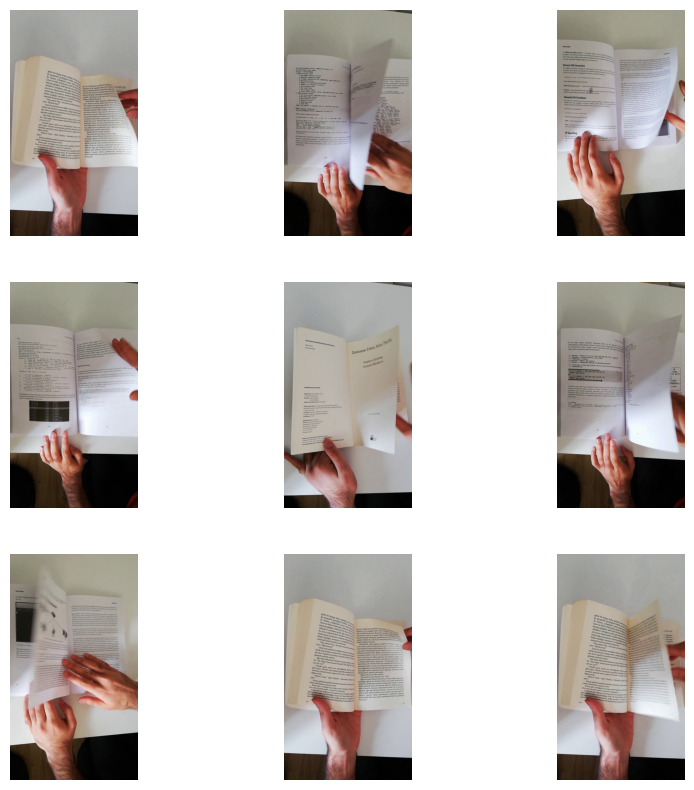

----------------------------------------------------------------------------------------------------


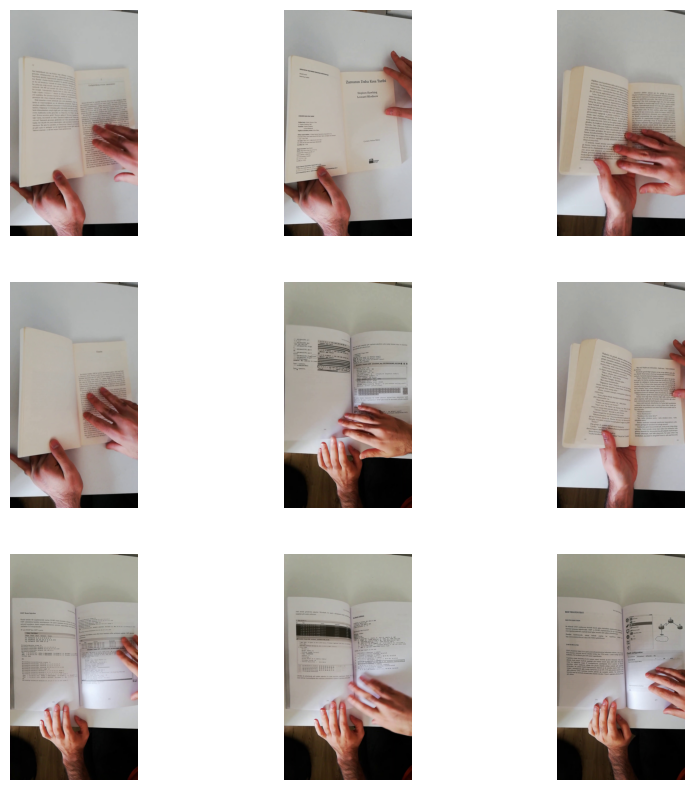

In [ ]:

def plot_random_images(image_paths, grid_size=3):
  fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
  for i, ax in enumerate(axs.flatten()):
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
  plt.show()

plot_random_images(train_flip_imgs)
print("-"*100)
plot_random_images(train_noflip_imgs)

In [ ]:
def f1_score(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # Ensure correct data type
  y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Threshold predictions to 0/1

  tp = tf.reduce_sum(y_true * y_pred)
  fp = tf.reduce_sum(y_pred * (1 - y_true))
  fn = tf.reduce_sum((1 - y_pred) * y_true)

  precision = tp / (tp + fp + tf.keras.backend.epsilon())
  recall = tp / (tp + fn + tf.keras.backend.epsilon())

  f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

  return f1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

model = Sequential(
    [
        layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            input_shape=(224, 224, 3)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │          93,314 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,834 (386.07 KB)

 Trainable params: 98,834 (386.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 525s 8s/step - f1_score: 0.5770 - loss: 0.8330 - val_f1_score: 0.5610 - val_loss: 0.6488
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 578ms/step - f1_score: 0.7605 - loss: 0.5249 - val_f1_score: 0.6072 - val_loss: 0.9802
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 536ms/step - f1_score: 0.8971 - loss: 0.2722 - val_f1_score: 0.6194 - val_loss: 1.3083
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 622ms/step - f1_score: 0.9349 - loss: 0.1845 - val_f1_score: 0.6004 - val_loss: 1.7063
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 569ms/step - f1_score: 0.9644 - loss: 0.1228 - val_f1_score: 0.5872 - val_loss: 2.1397


In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 237s 13s/step - f1_score: 0.7206 - loss: 1.3216


[0.5240740180015564, 0.8766447305679321]

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - f1_score: 0.8700 - loss: 0.2627 - val_f1_score: 0.9290 - val_loss: 0.2080
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 671ms/step - f1_score: 0.9971 - loss: 0.0140 - val_f1_score: 0.8829 - val_loss: 0.5569
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 665ms/step - f1_score: 1.0000 - loss: 0.0056 - val_f1_score: 0.9790 - val_loss: 0.0569
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 694ms/step - f1_score: 1.0000 - loss: 3.7330e-04 - val_f1_score: 0.9768 - val_loss: 0.0635
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 656ms/step - f1_score: 1.0000 - loss: 3.9297e-04 - val_f1_score: 0.9750 - val_loss: 0.0736


In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 695ms/step - f1_score: 0.9824 - loss: 0.0640


[0.0478481762111187, 0.9868420958518982]

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        MobileNetV3Small(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 940,274 (3.59 MB)

 Trainable params: 928,162 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset
)

Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - f1_score: 0.7384 - loss: 0.5557 - val_f1_score: 0.5251 - val_loss: 0.8957
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 547ms/step - f1_score: 0.9725 - loss: 0.1634 - val_f1_score: 0.5156 - val_loss: 1.3060
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 569ms/step - f1_score: 0.9954 - loss: 0.0365 - val_f1_score: 0.5144 - val_loss: 1.6071


In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 698ms/step - f1_score: 0.2086 - loss: 2.3232


[1.4392807483673096, 0.5279605388641357]

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

train_val_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_dataset = train_val_generator.flow_from_directory(
                          train_path,
                          target_size=(224, 224),
                          batch_size=32,
                          class_mode='categorical',
                          shuffle=True,
                          subset='training'
                  )

val_dataset = train_val_generator.flow_from_directory(
                      train_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=True,
                      subset='validation'
                  )


test_dataset = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                      test_path,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='categorical',
                      shuffle=False
                  )

model = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        EfficientNetB0(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet'
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.BinaryCrossentropy(),
    metrics=[f1_score]
)

model.summary()

Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - f1_score: 0.7489 - loss: 0.5043 - val_f1_score: 0.7969 - val_loss: 0.4129
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 574ms/step - f1_score: 0.9896 - loss: 0.0675 - val_f1_score: 0.8392 - val_loss: 0.3545
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - f1_score: 0.9908 - loss: 0.0252 - val_f1_score: 0.9417 - val_loss: 0.1469
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 597ms/step - f1_score: 0.9983 - loss: 0.0116 - val_f1_score: 0.9540 - val_loss: 0.1160
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - f1_score: 0.9982 - loss: 0.0097 - val_f1_score: 0.9456 - val_loss: 0.1343


In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 823ms/step - f1_score: 0.9486 - loss: 0.1224


[0.053587328642606735, 0.9786184430122375]

In [ ]:
predicted_labels = model.predict(test_dataset)
predicted_labels = np.argmax(predicted_labels, axis=1)

noflip_indices = np.where(predicted_labels == 0)[0].tolist()

predicted_noflip_images = [os.path.join(test_path, test_dataset.filenames[i]) for i in noflip_indices]

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 789ms/step


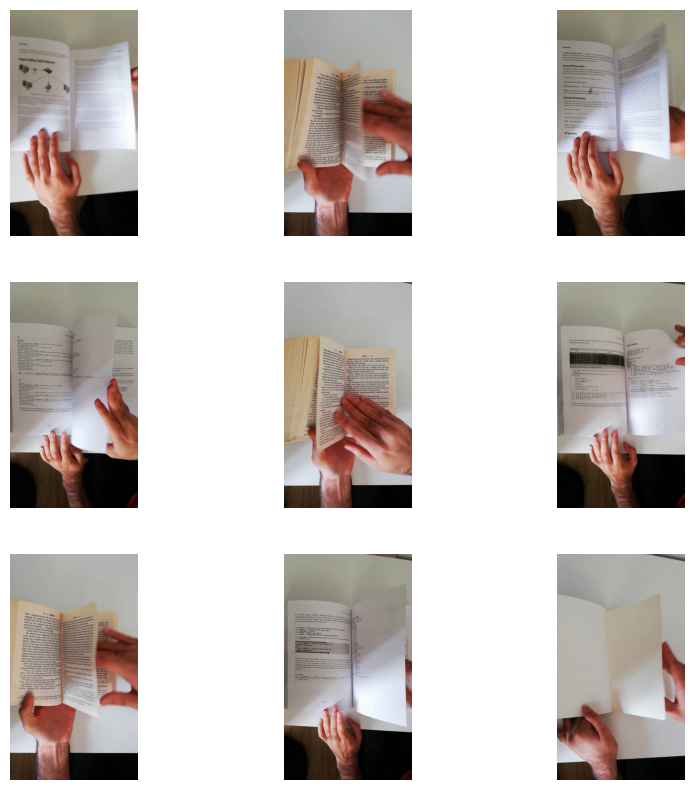

In [ ]:
plot_random_images(predicted_noflip_images)

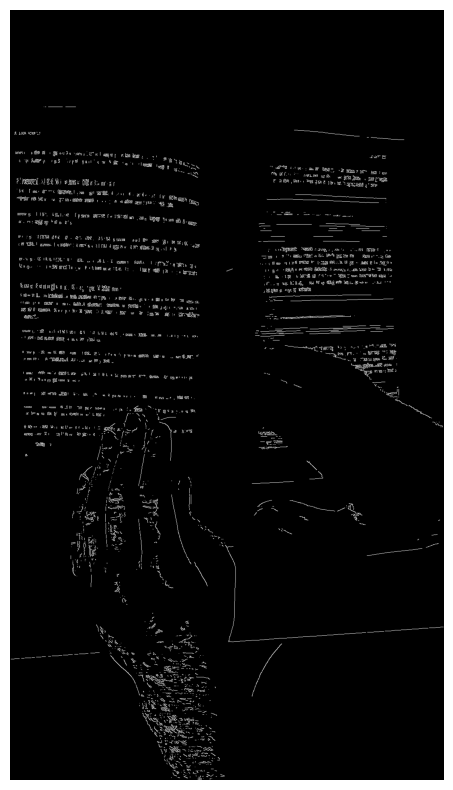

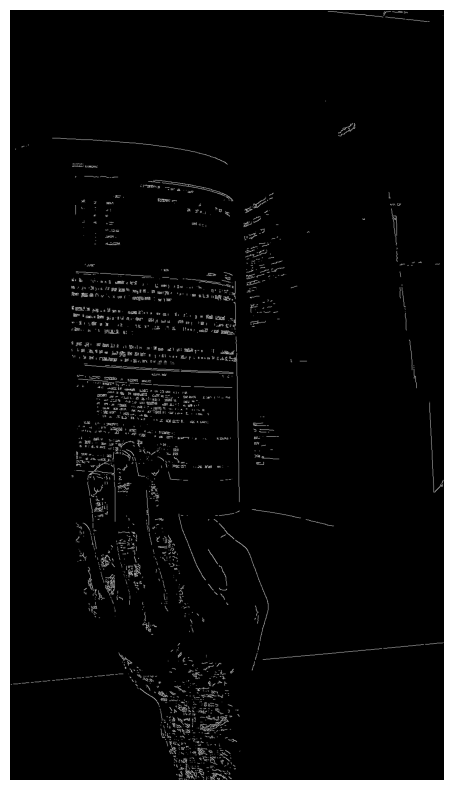

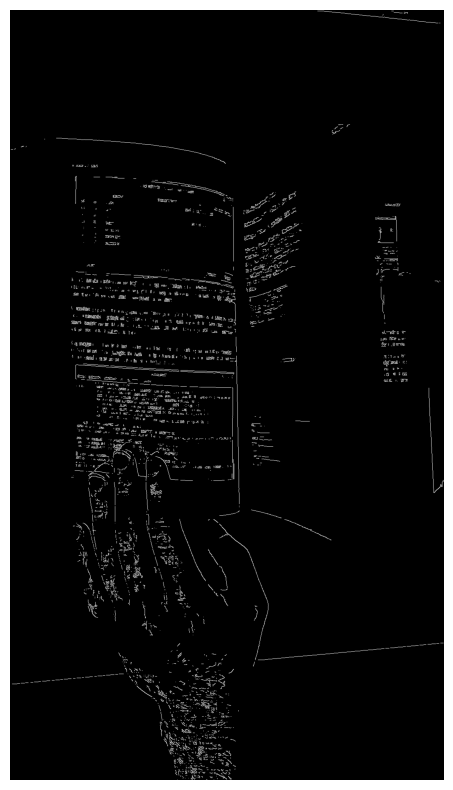

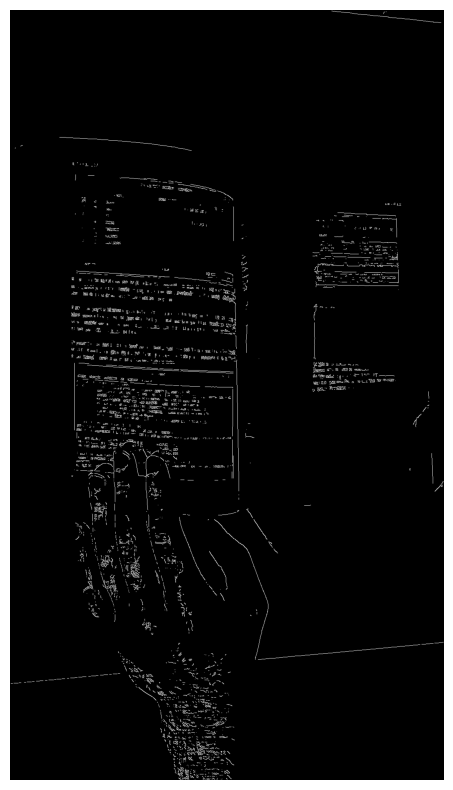

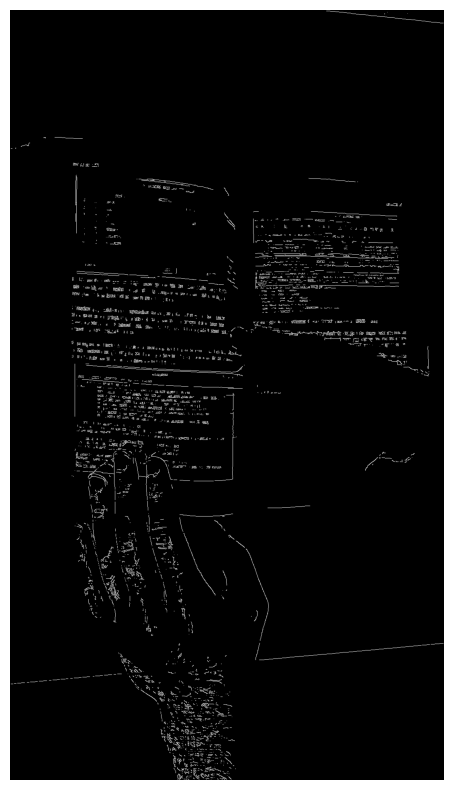

In [ ]:
# detect contours

for img in predicted_noflip_images[:5]:
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.Canny(img, 50, 100)
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # make it red
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
def preprocess_predicted_noflip_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.Canny(img, 100, 200)
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # make it red
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  img = cv2.resize(img, (224, 224))
  img = img / 255
  return img

preprocessed_predicted_noflip_imgs = [
    preprocess_predicted_noflip_image(img) for img in predicted_noflip_images
]

In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,885 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract as pt
from PIL import Image

def ocr(img):
  img = Image.fromarray(img).convert('L')
  text = pt.image_to_string(img)
  return text

predicted_texts = [ocr(img) for img in preprocessed_predicted_noflip_imgs]

predicted_texts[:5]

['\x0c', '\x0c', '\x0c', '\x0c', '\x0c']

In [ ]:
!python -m pip install paddlepaddle
!pip install "paddleocr>=2.0.1"

from paddleocr import PaddleOCR, draw_ocr

In [ ]:
model = PaddleOCR(use_angle_cls=True, lang='en')

img = predicted_noflip_images[0]

result = model.ocr(img, cls=True)

for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

NameError: name 'PaddleOCR' is not defined